## Набиуллин Иван Павлович

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Предварительная обработка данных
- Отрицательные значения объемов продаж заменяю на 0 (в этот день ничего не продали, лучше недооценить чем переоценить прибыль)
- Отрицательные значения цен заменяю средней по группе день - продукт - товар
- С данными конкурентов и погоды все хорошо

In [3]:
competitors = pd.read_parquet("df_competitors.parquet")
cost = pd.read_parquet("df_cost.parquet")
transactions = pd.read_parquet("transaction_df.parquet")
weather = pd.read_parquet("weather_df.parquet")

In [9]:
pd.crosstab(transactions['product'].head(20), transactions['price'].head(20))

price,-7154.53,3.90
product,,
Целебные травы,1,19


In [1199]:
transactions['amount'] = transactions['amount'].apply(lambda x: max(0, x)) 
transactions = transactions.dropna(subset=['place'])
any_na = transactions.isna().any().any()
print(any_na)

False


In [1200]:
transactions.sort_values(by='datetime', ascending=True, inplace=True)
transactions['day'] = pd.to_datetime(transactions['datetime']).dt.date

# Группируем по дням, продуктам и городам
grouped_data = transactions.groupby(['day', 'product', 'place'])

# Считаем среднюю цену для каждой комбинации, не учитывая отрицательные цены
average_price_data = grouped_data['price'].apply(lambda x: x[x >=0].mean()).reset_index()
average_price_data.columns = ['day', 'product', 'place', 'correct_price']

transactions = transactions.merge(average_price_data, on=['day', 'product', 'place'], how='left')

# Заменяем отрицательные цены средними ценами за день
transactions['price'] = transactions.apply(
    lambda row: row['correct_price'] if row['price'] < 0 else row['price'], axis=1)
transactions = transactions.drop(columns=['correct_price'])

In [1201]:
transactions.head()

,product,price,amount,place,datetime,day
0,Целебные травы,6.39,0.213086,Фалькония,2216-01-02 00:08:00,2216-01-02
1,Целебные травы,7.29,1.061766,Врата Балдура,2216-01-02 00:10:00,2216-01-02
2,Целебные травы,3.69,0.536039,Кеджистан,2216-01-02 00:10:00,2216-01-02
3,Эстус,4.19,0.149083,Кеджистан,2216-01-02 00:12:00,2216-01-02
4,Целебные травы,7.29,0.913862,Врата Балдура,2216-01-02 00:13:00,2216-01-02


In [1202]:
# Отрицательных цен больше нет
transactions[transactions['price']<=0]

,product,price,amount,place,datetime,day


In [1203]:
# В какой-то комбинации город-товар-день могло быть ничего не продано
# Поэтому делаем датафрейм с уникальными комбинациями
days=transactions['day'].unique()
places = transactions['place'].unique()
products = transactions['product'].unique()
all_combinations = pd.DataFrame([(place, day, product) for place in places for day in days for product in products],
                                columns=['place', 'day', 'product'])

# Соединяем датафреймы чтобы не потерять при группировке комбинации где не было транзакций
transactions = all_combinations.merge(transactions, on=['place', 'day', 'product'], how='left')

In [1204]:
# Двух комбинаций не было
missing_data = transactions[(transactions['price'].isna()) | (transactions['amount'].isna())]
print(missing_data)

                place         day            product  price  amount datetime
260152  Врата Балдура  2217-04-03  Эльфийская пыльца    NaN     NaN      NaT
267486  Врата Балдура  2217-07-01  Эльфийская пыльца    NaN     NaN      NaT


In [1205]:
# Количество заполним нулями, а цену ценой за предыдущий день для того же товара - города

transactions.sort_values(['place', 'product', 'day'], inplace=True)
transactions['amount'].fillna(0, inplace=True)
transactions['price'] = transactions.groupby(['place', 'product'])['price'].fillna(method='ffill')

In [1206]:
# Проверка на NaN
missing_data = transactions[(transactions['price'].isna()) | (transactions['amount'].isna())]
print(missing_data)
# Теперь все в порядке

Empty DataFrame
Columns: [place, day, product, price, amount, datetime]
Index: []


In [1207]:
transactions = transactions.groupby(['place', 'day', 'product']).agg({
    'price': 'mean',
    'amount': 'sum',
}).reset_index()

In [1208]:
transactions.shape

(15000, 5)

In [1209]:
# Данные о разных конкурентах группируем и приводим к минимальным, средним и максимальным ценам в каждой группе

competitors = competitors.groupby(['date', 'place', 'product'])['price'].agg(
    competitors_min='min',
    competitors_mean='mean',
    competitors_max='max'
).reset_index()

In [1210]:
all_combinations = all_combinations.rename({'day' : 'date'} , axis=1)
all_combinations['date'] = pd.to_datetime((all_combinations['date']))

In [1211]:
# Не хватает данных о себестоимости
cost['date'].nunique()
cost_no_missing = all_combinations.merge(cost, on=['place', 'date', 'product'], how='left')

# Применяем линейную интерполяцию для того, чтобы заполнить пропуски в каждой группе себестоимостей
cost_no_missing['cost'] = cost_no_missing.sort_values('date').\
                        groupby(['place', 'product'])['cost'].transform(lambda group: group.interpolate(method='linear'))

In [1212]:
# Здесь начинаем собирать все воедино
transactions = transactions.rename({'day' : 'date'}, axis=1)
transactions['date'] = pd.to_datetime(transactions['date'])
transactions = transactions.merge(weather, on=['date', 'place']).sort_values('date')
transactions = transactions.merge(cost_no_missing, on=['date', 'place', 'product'], how='left').sort_values('date')

In [1213]:
competitors_full = all_combinations.merge(competitors, on=['place', 'date', 'product'], how='left').sort_values('date').reset_index()
competitors_full = competitors_full.drop('index', axis=1)

# Заполняем NaN значения линейной интерполяцией
competitors_full['competitors_min'] = (competitors_full.sort_values('date')
                                    .groupby(['place', 'product'])['competitors_min']
                                       .transform(lambda group: group.interpolate(method='linear')))
competitors_full['competitors_mean'] = competitors_full.sort_values('date')\
                                    .groupby(['place', 'product'])['competitors_mean']\
                                        .transform(lambda group: group.interpolate(method='linear'))
competitors_full['competitors_max'] = competitors_full.sort_values('date')\
                                    .groupby(['place', 'product'])['competitors_max']\
                                        .transform(lambda group: group.interpolate(method='linear'))

# Заполняем оставшиеся 2 NaN значения
competitors_full = competitors_full.fillna(method = 'bfill')

In [1214]:
# Общий датафрейм для последующей работы
df_all = transactions.merge(competitors_full, on=['date', 'place', 'product'], how='left')

# Функции

In [1215]:
# Кросс валидация для временных рядов
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):

    k = int(np.floor(float(X_train.shape[0]) / number_folds))

    errors = np.zeros(number_folds - 1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        split = float(i - 1) / i

        X = X_train[:(k * i)]
        y = y_train[:(k * i)]

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i - 2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [1216]:
# Функция для приведения цен к ступенчатому виду (для соблюдения правил чемпионата)
def make_stepped(raw_preds):
    new_preds = []
    days_without_change = 0
    last_price = raw_preds[0]
    new_preds.append(raw_preds[0])
    for cur_price in raw_preds[1:]:
        if days_without_change == 3:
            days_without_change = 0
            diff = cur_price - last_price
            if diff > 1:
                last_price = last_price + 1
            if diff < -1:
                last_price = last_price - 1
            if -1 <= diff < 0:
                last_price -= np.round(abs(diff), 2)
            if 0 <= diff <= 1:
                last_price += np.round(diff, 2)

            new_preds.append(last_price)
        else:
            days_without_change += 1
            new_preds.append(last_price)
            continue

    return np.round(new_preds, 2)

In [1217]:
# Функция для нахождения минимумов временного ряда (в итоговом решении не используется)
def make_min_fun(df_comp_min):
    min_valuess = df_comp_min['competitors_min'].groupby(df_comp_min.index // 100).min()
    result = np.interp(df_comp_min.index, min_valuess.index * 100, min_valuess)
    return pd.Series(result) #

# Изучение зависимостей, выбор модели, создание фичей, подбор параметров

In [1218]:
# Корреляции для каждой из 15 комбинаций Город-Товар

price_amount_corrs = {}
for place in transactions['place'].unique():
    for product in transactions['product'].unique():
        price_amount_corrs[(place, product)] = transactions[(transactions['product'] == product) & (transactions['place'] == place)] \
            .sort_values('date')['price'].corr(transactions[(transactions['product'] == product) & (transactions['place'] == place)] \
                                               .sort_values('date')['amount'])
pd.Series(price_amount_corrs.values(), name='amount-price_corr').sort_values(ascending=False)

#Объемы продаж и цены почти не коррелируют между собой (отсортировал по убыванию):

8     0.172060
4     0.061915
5     0.039759
13    0.028467
10    0.027222
14    0.026409
7     0.012003
2     0.001146
6    -0.012476
9    -0.012506
12   -0.032288
1    -0.050855
0    -0.085865
3    -0.110262
11   -0.147018
Name: amount-price_corr, dtype: float64

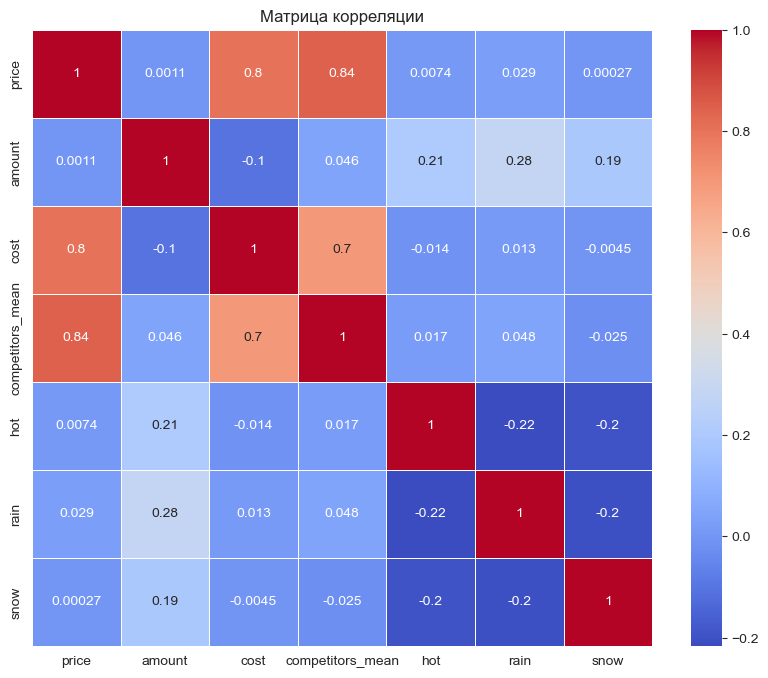

In [1219]:
place, product = 'Анор Лондо', 'Эстус'
corr_matrix2 = df_all.sort_values('date')[(df_all['place'] == f'{place}') & (df_all['product'] == f'{product}')] \
    [['price', 'amount', 'cost',  'competitors_mean', 'hot', 'rain', 'snow']].corr()
plt.figure(figsize=(10, 8))  # Размер графика
sns.heatmap(corr_matrix2, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляции")
plt.show()

# Здесь я вручную смотрел на все корреляции признаков в каждой комбинации, для того чтобы сделать примерный
# выбор зависимых переменных для модели

### Изучил корреляции по каждой комбинации Город - Товар:
-Цена, себестоимость и средняя цена конкурентов сильно коррелируют друг с другом.
-Объемы продаж склонны зависеть от погоды

In [1220]:
# Как модель я выбрал линейную регрессию без регуляризаций. В этом блоке кода подбирал параметры.
# Учитывая, что мы предсказываем временной ряд, нужно обозначить временную зависимость. Я использовал Lag фичи.
# Так же пробовал использовать библиотеку tsfresh, которая достает фичи из временного ряда, но с ней мои результаты были хуже
# поэтому блок кода закомменчен

predictions_train = {}
predictions_valid = {}
predictions_test = {}
errors_cv = {}
errors_rmse = {}
errors_mape = {}
for place in tqdm(transactions['place'].unique()):
    for product in transactions['product'].unique():
        combo = (place, product)
        cur_df = df_all[(df_all['place'] == place) & (df_all['product'] == product)].drop(columns=['place', 'product']).sort_values('date').reset_index(drop=True)
        cur_df['date_index'] = np.arange(len(cur_df.index))
        cur_df['moving_avg_price'] = cur_df['price'].rolling(
            window=50,
            center=True,
            min_periods=10
        ).mean()
        cur_df['moving_avg_cost'] = cur_df['cost'].rolling(
            window=25,
            center=True,
            min_periods=10
        ).mean()

        X = cur_df.sort_values('date').reset_index(drop=True)[[]]
        y = cur_df.sort_values('date').reset_index(drop=True)['price']

        test_size_coef = 0.7
        lag_start = 90
        lag_end = 100
        for lag in range(lag_start, lag_end):
            X[f'lag_price_{lag}'] = cur_df['price'].shift(lag)
            X[f'lag_mov_avg_price_{lag}'] = cur_df['moving_avg_price'].shift(lag)
            X[f'lag_cost_{lag}'] = cur_df['moving_avg_cost'].shift(lag)
        X = X[lag_end-1:]
        y = y[lag_end-1:]

        # data_long = pd.DataFrame({0: X.values.flatten(),
        #                           1: np.arange(X.shape[0]).repeat(X.shape[1])})
        # from tsfresh.feature_extraction import settings
        # settings = settings.MinimalFCParameters()
        # extracted_features = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings, disable_progressbar=True)
        # impute(extracted_features)
        # features_filtered = select_features(extracted_features, y.reset_index(drop=True))
        # X = pd.concat([X.reset_index(drop=True), features_filtered.reset_index(drop=True)], axis=1)

        X_train = X[:int(len(X)*test_size_coef)]
        y_train = y[:int(len(X)*test_size_coef)]

        X_valid = X[int(len(X)*test_size_coef): 810]
        y_valid = y[int(len(X)*test_size_coef): 810]

        X_test = X[-100:]
        y_test = y[-100:]
        model_lr = Ridge(alpha=50)
        model_lr.fit(X_train, y_train)
        predictions_train[combo] = model_lr.predict(X_train)
        predictions_valid[combo] = model_lr.predict(X_valid)
        predictions_test[combo] = model_lr.predict(X_test)

        errors_rmse[combo] = [np.sqrt(mean_squared_error(y_train, predictions_train[combo])),
                              np.sqrt(mean_squared_error(y_valid, predictions_valid[combo])),
                              np.sqrt(mean_squared_error(y_test, predictions_test[combo]))]
        errors_mape[combo] = [mean_absolute_percentage_error(y_train, predictions_train[combo]),
                              mean_absolute_percentage_error(y_valid, predictions_valid[combo]),
                              mean_absolute_percentage_error(y_test, predictions_test[combo])]
        errors_cv[combo] = np.sqrt(performTimeSeriesCV(X_train, y_train, 7, model_lr, mean_squared_error))
        # Кросс валидация на 7 фолдов, потому что тогда каждый фолд получится 90 дней.

100%|██████████| 5/5 [00:00<00:00,  7.62it/s]


In [1221]:
# Понимаю что мог бы сразу создать датафреймы (а не словари), и складывать все предсказания и ошибки туда,
# но понял это слишком поздно)

df_predictions_train = pd.DataFrame(list(predictions_train.items()), columns=['Combo', 'Prediction'])
df_predictions_train[['Place', 'Product']] = pd.DataFrame(df_predictions_train['Combo'].tolist(), index=df_predictions_train.index)
df_predictions_train = df_predictions_train[['Prediction', 'Place', 'Product']]

df_predictions_valid = pd.DataFrame(list(predictions_valid.items()), columns=['Combo', 'Prediction'])
df_predictions_valid[['Place', 'Product']] = pd.DataFrame(df_predictions_valid['Combo'].tolist(), index=df_predictions_valid.index)
df_predictions_valid = df_predictions_valid[['Prediction', 'Place', 'Product']]

df_predictions_test = pd.DataFrame(list(predictions_test.items()), columns=['Combo', 'Prediction'])
df_predictions_test[['Place', 'Product']] = pd.DataFrame(df_predictions_test['Combo'].tolist(), index=df_predictions_test.index)
df_predictions_test = df_predictions_test[['Prediction', 'Place', 'Product']]

df_errors_rmse = pd.DataFrame(list(errors_rmse.items()), columns=['Combo', 'Error_Value'])
df_errors_rmse[['Place', 'Product']] = pd.DataFrame(df_errors_rmse['Combo'].tolist(), index=df_errors_rmse.index)
df_errors_rmse[['Train_Err', 'Valid_Err', 'Test_Err']] = pd.DataFrame(df_errors_rmse['Error_Value'].tolist(), index=df_errors_rmse.index)
df_errors_rmse = df_errors_rmse[['Place', 'Product', 'Train_Err', 'Valid_Err', 'Test_Err']]

df_errors_mape = pd.DataFrame(list(errors_mape.items()), columns=['Combo', 'Error_Value'])
df_errors_mape[['Place', 'Product']] = pd.DataFrame(df_errors_mape['Combo'].tolist(), index=df_errors_mape.index)
df_errors_mape[['Train_Err', 'Valid_Err', 'Test_Err']] = pd.DataFrame(df_errors_mape['Error_Value'].tolist(), index=df_errors_mape.index)
df_errors_mape = df_errors_mape[['Place', 'Product', 'Train_Err', 'Valid_Err', 'Test_Err']]

df_errors_cv = pd.DataFrame(list(errors_cv.items()), columns=['Combo', 'Error_CV'])
df_errors_cv[['Place', 'Product']] = pd.DataFrame(df_errors_cv['Combo'].tolist(), index=df_errors_cv.index)
df_errors_cv['CV_Err'] = df_errors_cv['Error_CV'].apply(np.sqrt)
df_errors_cv = df_errors_cv[['Place', 'Product', 'CV_Err']]

In [1222]:
# Удобная функция для построения графиков (с ней я тестировал, подбирал параметры)
# Эта функция не лежит в разделе функции, потому что тут напрямую используются
# предсказания, которые были получены клеткой кода выше
def plot_predictions(place, product, title=''):
    df_to_plot = df_all[(df_all['place'] == place) & (df_all['product'] == product)]
    df_to_plot = df_to_plot[lag_end:]
    if title == 'train':
        y1_to_plot = df_to_plot['price'][:int(len(X)*test_size_coef)]
        y2_to_plot = list(df_predictions_train[(df_predictions_train['Place'] == place) & (df_predictions_train['Product'] == product)]['Prediction'])[0]
        indices = range(0, len(y1_to_plot))
    if title == 'valid':
        y1_to_plot = df_to_plot['price'][int(len(X)*test_size_coef): 810]
        y2_to_plot = list(df_predictions_valid[(df_predictions_valid['Place'] == place) & (df_predictions_valid['Product'] == product)]['Prediction'])[0]
        indices = range(int(len(X)*test_size_coef), 810)
    if title == 'test':
        y1_to_plot = df_to_plot['price'][-100:]
        y2_to_plot = list(df_predictions_test[(df_predictions_test['Place'] == place) & (df_predictions_test['Product'] == product)]['Prediction'])[0]
        indices = range(900, 1000)

    plt.figure(figsize=(20, 4))
    # Истинные значения (синяя ломаная линия)
    plt.plot(indices, y1_to_plot, linestyle='-', color='blue', label='Истинные значения')

    # Предсказанные значения (красная ломаная линия)
    plt.plot(indices, y2_to_plot, linestyle='-', color='red', label='Предсказанные значения')

    # Добавьте подписи и легенду
    plt.title(title)
    plt.xlabel('Date index')
    plt.ylabel('Price')
    plt.legend()

    # Отобразите сетку для лучшей видимости
    plt.grid(True, linestyle='--', alpha=0.7)

    # Отобразите график
    plt.show()

In [1223]:
print("RMSE: ", round(df_errors_rmse['Valid_Err'].mean(), 4))
print("MAPE: ",  round(df_errors_mape['Valid_Err'].mean()*100, 4))
print("CrossValidation: ", round(df_errors_cv['CV_Err'].mean(), 4))

RMSE:  0.6569
MAPE:  4.0627
CrossValidation:  0.8067


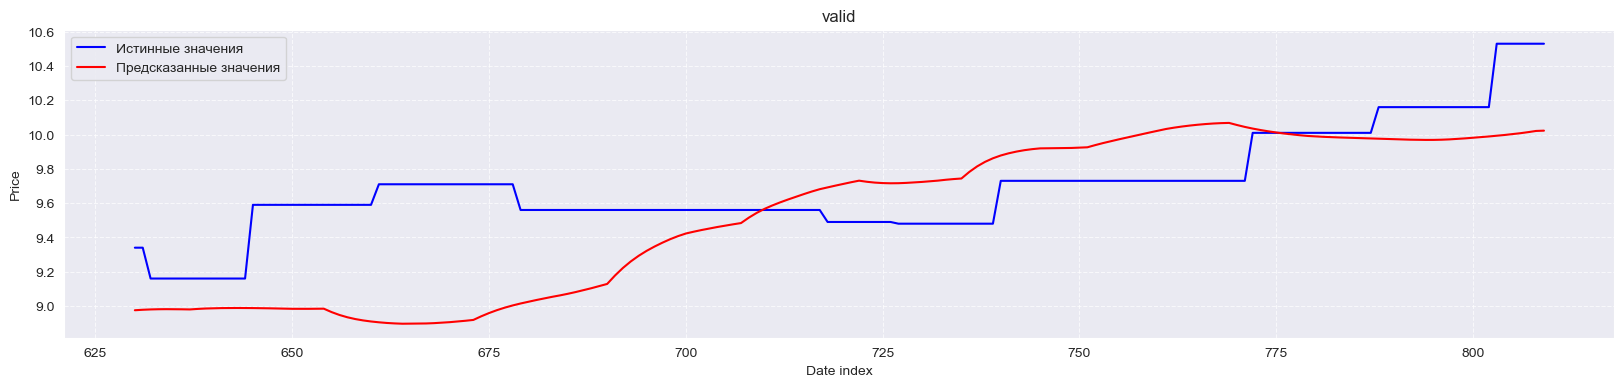

In [1224]:
plot_predictions('Фалькония', 'Целебные травы', 'valid')

# Строим и тестируем модель для предсказания цен соперников

In [1225]:
# Увидел, что средние цены конкурентов очень хорошо опишутся линейной регрессией с одним параметром.
# Мне нужны предсказания цен соперников для того, чтобы оценить превышение в 20%

predictions_competitors_train = {}
predictions_competitors_valid = {}
errors_competitors_cv = {}
for place in tqdm(transactions['place'].unique()):
    for product in transactions['product'].unique():
        combo = (place, product)
        cur_df = df_all[(df_all['place'] == place) & (df_all['product'] == product)].drop(columns=['place', 'product']).sort_values('date').reset_index(drop=True)
        cur_df['date_index'] = np.arange(len(cur_df.index))
        
        X_comp = cur_df.sort_values('date').reset_index(drop=True)[['date_index']]
        y_comp = cur_df.sort_values('date').reset_index(drop=True)['competitors_mean']

        test_size_coef_comp = 0.8

        X_train_comp = X_comp[:int(len(X_comp)*test_size_coef_comp)]
        y_train_comp = y_comp[:int(len(X_comp)*test_size_coef_comp)]

        X_valid_comp = X_comp[int(len(X_comp)*test_size_coef_comp):]
        y_valid_comp = y_comp[int(len(X_comp)*test_size_coef_comp):]
        model_lr_comp = LinearRegression()
        model_lr_comp.fit(X_train_comp, y_train_comp)
        predictions_competitors_train[combo] = model_lr_comp.predict(X_train_comp)
        predictions_competitors_valid[combo] = model_lr_comp.predict(X_valid_comp)

        errors_competitors_cv[combo] = np.sqrt(performTimeSeriesCV(X_train_comp, y_train_comp, 7, model_lr_comp, mean_squared_error))

        # Можно раскомментировать и посмотреть на построенные лин регрессии:
        
        # plt.plot(range(800) ,y_train_comp)                        
        # plt.plot(range(800) ,predictions_competitors_train[combo])  
        # plt.title(place + ' ' + product)
        # plt.show()

100%|██████████| 5/5 [00:00<00:00, 20.00it/s]


In [1226]:
# Средняя ошибка кросс валидации 0.7, что совсем неплохо, т.к. предсказания цен конкурентов нужны лишь для того, чтобы
# найти, где предсказанные значения превышают цены конкурентов больше, чем на 20%

df_errors_competitors_cv = pd.DataFrame(list(errors_competitors_cv.items()), columns=['Combo', 'Error_Value'])
df_errors_competitors_cv[['Place', 'Product']] = pd.DataFrame(df_errors_competitors_cv['Combo'].tolist(), index=df_errors_competitors_cv.index)
print("CV on competitors_mean: ", df_errors_competitors_cv['Error_Value'].mean())

CV on competitors_mean:  0.7151375276607649


# Предсказываем, уточняем
Тут тот же код что и раньше, только уже без деления на выборки. Предсказываем на 90 дней вперед. Затем собираем все вместе.

In [1227]:
# Предсказываем среднюю цену конкурентов

predictions_competitors_mean = {}
for place in tqdm(transactions['place'].unique()):
    for product in transactions['product'].unique():
        combo = (place, product)
        cur_df = df_all[(df_all['place'] == place) & (df_all['product'] == product)].drop(columns=['place', 'product']).sort_values('date').reset_index(drop=True)
        cur_df['date_index'] = np.arange(len(cur_df.index))

        X_comp = cur_df.sort_values('date').reset_index(drop=True)[['date_index']]
        y_comp = cur_df.sort_values('date').reset_index(drop=True)['competitors_mean']

        model_lr_comp = LinearRegression()
        model_lr_comp.fit(X_comp, y_comp)
        predictions_competitors_mean[combo] = model_lr_comp.predict(pd.DataFrame({'date_index': range(1000, 1090)}))

df_predictions_comp_mean = pd.DataFrame(list(predictions_competitors_mean.items()), columns=['Combo', 'Prediction'])
df_predictions_comp_mean[['Place', 'Product']] = pd.DataFrame(df_predictions_comp_mean['Combo'].tolist(), index=df_predictions_comp_mean.index)
df_predictions_comp_mean = df_predictions_comp_mean[['Place', 'Product', 'Prediction']]

100%|██████████| 5/5 [00:00<00:00, 63.99it/s]


In [1228]:
# Предсказываем наши цены

predictions_price = {}
for place in tqdm(transactions['place'].unique()):
    for product in transactions['product'].unique():
        combo = (place, product)
        cur_df = df_all[(df_all['place'] == place) & (df_all['product'] == product)].drop(columns=['place', 'product']).sort_values('date').reset_index(drop=True)
        cur_df['date_index'] = np.arange(len(cur_df.index))
        cur_df['moving_avg_price'] = cur_df['price'].rolling(
            window=50,
            center=True,
            min_periods=10
        ).mean()
        cur_df['moving_avg_cost'] = cur_df['cost'].rolling(
            window=25,
            center=True,
            min_periods=10
        ).mean()

        X = cur_df.sort_values('date').reset_index(drop=True)[[]]
        y = cur_df.sort_values('date').reset_index(drop=True)['price']

        X_pred = pd.DataFrame()

        lag_start = 90
        lag_end = 100
        for lag in range(lag_start, lag_end):

            X_pred[f'lag_price_{lag}'] =  cur_df['price'][-lag:].head(90).reset_index(drop=True)
            X_pred[f'lag_mov_avg_price_{lag}'] = cur_df['moving_avg_price'][-lag:].head(90).reset_index(drop=True)
            X_pred[f'lag_cost_{lag}'] = cur_df['moving_avg_cost'][-lag: ].head(90).reset_index(drop=True)
            
            X[f'lag_price_{lag}'] = cur_df['price'].shift(lag)
            X[f'lag_mov_avg_price_{lag}'] = cur_df['moving_avg_price'].shift(lag)
            X[f'lag_cost_{lag}'] = cur_df['moving_avg_cost'].shift(lag)
        X = X[lag_end:].reset_index(drop=True)
        y = y[lag_end:].reset_index(drop=True)

        model_lr = Ridge(alpha=50)
        model_lr.fit(X, y)
        predictions_price[combo] = model_lr.predict(X_pred)

df_predictions_price = pd.DataFrame(list(predictions_price.items()), columns=['Combo', 'Prediction'])
df_predictions_price[['Place', 'Product']] = pd.DataFrame(df_predictions_price['Combo'].tolist(), index=df_predictions_price.index)
df_predictions_price = df_predictions_price[['Place', 'Product', 'Prediction']]

100%|██████████| 5/5 [00:00<00:00, 16.00it/s]


In [1229]:
# Собираем предсказания о наших ценах и о ценах конкурентов в один датафрейм.
# Сравниваем цены, если наши цены превышают цены конкурентов больше чем на 20%,
# то ставим в этот день цену равную 1.2*конкурента

df_merged_predictions = pd.merge(df_predictions_price, df_predictions_comp_mean, on=['Place', 'Product'], suffixes=('_mine', '_competitor'))

def adjust_prices(row):
    mine_prices = np.array(row['Prediction_mine'])
    competitor_prices = np.array(row['Prediction_competitor'])
    exceeds_by_20_percent = mine_prices > competitor_prices * 1.2
    mine_prices[exceeds_by_20_percent] = competitor_prices[exceeds_by_20_percent] * 1.2
    return mine_prices.tolist()

df_merged_predictions['Prediction_no_20p'] = df_merged_predictions.apply(adjust_prices, axis=1)

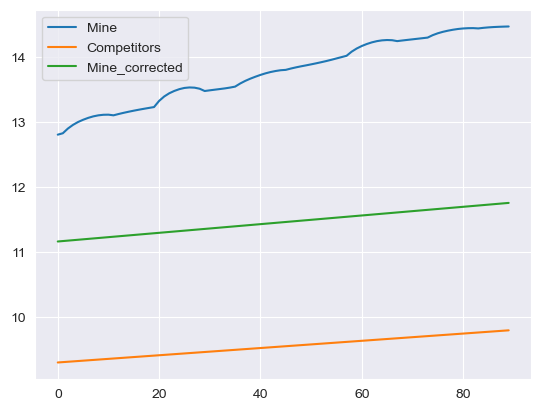

In [1230]:
# Результат корректировки цен на примере проблемной комбинации (таких было 2 из 15)

df_plot =df_merged_predictions[(df_merged_predictions['Place']  == 'Анор Лондо') & (df_merged_predictions['Product'] == 'Целебные травы')]
plt.plot(range(0,90),list(df_plot['Prediction_mine'])[0], label='Mine')
plt.plot(range(0,90),list(df_plot['Prediction_competitor'])[0],label='Competitors')
plt.plot(range(0,90),list(df_plot['Prediction_no_20p'])[0], label='Mine_corrected')
plt.legend()
plt.show()

In [1231]:
# Здесь я пересобираю датафрейм, т.к. нужно было привести результаты к ступенчатому виду
# (функция make_stepped, она же округляет до 2 знаков, описана в разделе Функции).

df_almost_final = pd.DataFrame(columns=['Place', 'Product', 'Final_prices'])
for index, row in df_merged_predictions.iterrows():
    new_data = {'Place': row['Place'], 'Product': row['Product'], 'Final_prices' : make_stepped(row['Prediction_no_20p'])}
    df_almost_final.loc[len(df_almost_final)] = new_data

In [1232]:
# И в конце приведение к нужному виду

df_transformed = pd.DataFrame(df_almost_final['Final_prices'].tolist(), index=df_almost_final.index).stack().reset_index()
df_transformed.columns = ['index', 'day_number', 'price']
df_transformed = df_transformed.join(df_almost_final[['Place', 'Product']], on='index').drop('index', axis=1)
df_transformed['day_number'] += 1
df_transformed = df_transformed.rename(columns={'Place' : 'place', 'Product' : 'product'})

In [1233]:
df_transformed.to_parquet("results.parquet")